# Histograms of Colors

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline,FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import make_column_transformer, make_column_selector
from custom import ColorHistogram, Splitter, CustomNormalizer, Loader
from sklearn import set_config
set_config(display="diagram")

## Creation

We first import the metadata and load only the images relative to `dev set` due to shortages of computation power.

In [8]:
metadata = pd.read_csv('dataset/metadata.csv', index_col=['src','slice_num'])
# metadata.loc[metadata.partition=='dev','features'] = metadata[metadata.partition=='dev'].img_slice.apply(lambda x: np.load(x))
dev_data = metadata[metadata.partition=='dev']
dev_data.head()

img_slice  \
src slice_num                                              
0   79         og_dataset/splits/dev/slice_0_img_079.npy   
    121        og_dataset/splits/dev/slice_0_img_121.npy   
    174        og_dataset/splits/dev/slice_0_img_174.npy   
2   10         og_dataset/splits/dev/slice_2_img_010.npy   
    16         og_dataset/splits/dev/slice_2_img_016.npy   

                                               mask_slice  glaciers  \
src slice_num                                                         
0   79         og_dataset/splits/dev/slice_0_mask_079.npy       0.0   
    121        og_dataset/splits/dev/slice_0_mask_121.npy       0.0   
    174        og_dataset/splits/dev/slice_0_mask_174.npy       0.0   
2   10         og_dataset/splits/dev/slice_2_mask_010.npy       0.0   
    16         og_dataset/splits/dev/slice_2_mask_016.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   79                    0.0              0.0  142.014130  394523.684211   
    121                   0.0              0.0  113.703094  348977.894737   
    174                   0.0              0.0  112.221992  470433.333333   
2   10                    0.0              0.0  333.149292  317285.107228   
    16                    0.0              0.0  317.823853  180647.872461   

                        lat partition  label  
src slice_num                                 
0   79         3.648087e+06       dev    0.0  
    121        3.693633e+06       dev    0.0  
    174        3.739179e+06       dev    0.0  
2   10         3.414856e+06       dev    0.0  
    16         3.430038e+06       dev    0.0

### Pipeline
Now we create the pipeline that will handle our data and process each image into a set of features.

In [42]:
feature_names = ['LE7 B1 (blue)', 'LE7 B2 (green)', 'LE7 B3 (red)', 'LE7 B4 (near infrared)', 'LE7 B5 (shortwave infrared 1)', 'LE7 B6_VCID_1 (low-gain thermal infrared)', 'LE7 B6_VCID_2 (high-gain thermal infrared)', 'LE7 B7 (shortwave infrared 2)', 'LE7 B8 (panchromatic)', 'LE7 BQA (quality bitmask)', 'NDVI (vegetation index)', 'NDSI (snow index)', 'NDWI (water index)', 'SRTM 90 elevation', 'SRTM 90 slope']

normalization_file = 'og_dataset/stats_train.json'
import json
with open(normalization_file) as f:
    channels_stats = json.load(f)

pipe = make_column_transformer(
    (make_pipeline(
        CustomNormalizer(channels_stats['means'],channels_stats['stds']),
        Loader(),
        Splitter(feature_names),
        ColorHistogram()
    ), ['img_slice']),
)

histograms = pipe.fit_transform(dev_data)
histograms

KeyboardInterrupt: 

For each of the layers we can visualize the bin edges:

In [6]:
pipe.named_transformers_['pipeline'].named_steps['colorhistogram'].bins

{'LE7 B1 (blue)': array([-3.70359683, -3.47568939, -3.24778195, -3.01987451, -2.79196707,
        -2.56405964, -2.3361522 , -2.10824476, -1.88033732, -1.65242988,
        -1.42452244, -1.196615  , -0.96870756, -0.74080012, -0.51289268,
        -0.28498524, -0.05707781,  0.17082963,  0.39873707,  0.62664451,
         0.85455195,  1.08245939,  1.31036683,  1.53827427,  1.76618171,
         1.99408915,  2.22199659,  2.44990402,  2.67781146,  2.9057189 ,
         3.13362634,  3.36153378,  3.58944122,  3.81734866,  4.0452561 ,
         4.27316354,  4.50107098]),
 'LE7 B2 (green)': array([-2.69538379, -2.5051867 , -2.31498961, -2.12479252, -1.93459543,
        -1.74439834, -1.55420125, -1.36400416, -1.17380706, -0.98360997,
        -0.79341288, -0.60321579, -0.4130187 , -0.22282161, -0.03262452,
         0.15757257,  0.34776966,  0.53796675,  0.72816384,  0.91836093,
         1.10855802,  1.29875511,  1.4889522 ,  1.67914929,  1.86934638,
         2.05954347,  2.24974056,  2.43993765,  2.630

And also the number of bins for each layer:

In [7]:
print('Bin size for each column')
fitted_bins = pipe.transformers_[0][1].steps[3][1].bins
for col, bin in fitted_bins.items():
    print(f'{col:45} {len(bin)}')

Bin size for each column
LE7 B1 (blue)                                 37
LE7 B2 (green)                                37
LE7 B3 (red)                                  37
LE7 B4 (near infrared)                        38
LE7 B5 (shortwave infrared 1)                 38
LE7 B6_VCID_1 (low-gain thermal infrared)     37
LE7 B6_VCID_2 (high-gain thermal infrared)    35
LE7 B7 (shortwave infrared 2)                 39
LE7 B8 (panchromatic)                         38
LE7 BQA (quality bitmask)                     35
NDVI (vegetation index)                       38
NDSI (snow index)                             38
NDWI (water index)                            38
SRTM 90 elevation                             37
SRTM 90 slope                                 35


Finally we assemble everything into a nice and tidy pandas Dataframe.

In [8]:
bin_lens = {col:len(bin)-1 for col, bin in fitted_bins.items()}
new_cols = [(col, i) for col, length in bin_lens.items() for i in range(length)]
dev_hist = pd.DataFrame(histograms, columns=pd.MultiIndex.from_tuples(new_cols))
dev_hist.index = dev_data.index
dev_hist.head()

LE7 B1 (blue)                                               \
                         0    1    2    3    4    5    6    7         8    
src slice_num                                                              
0   79                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
    121                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000318   
    174                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
2   10                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN   
    16                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN   

                         ... SRTM 90 slope                                     \
                     9   ...            24        25   26   27   28   29   30   
src slice_num            ...                                                    
0   79         0.000000  ...           0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
    121        0.000502  ...           0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
    174        0.000000  ...           0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
2   10              NaN  ...           0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
    16              NaN  ...           0.0  0.000242  0.0  0.0  0.0  0.0  0.0   

                              
                31   32   33  
src slice_num                 
0   79         0.0  0.0  0.0  
    121        0.0  0.0  0.0  
    174        0.0  0.0  0.0  
2   10         0.0  0.0  0.0  
    16         0.0  0.0  0.0  

[5 rows x 542 columns]

In [9]:
dev_hist.to_csv('dataset/dev_hist.csv')

In [14]:
train_data = metadata[metadata.partition=='train']
test_data = metadata[metadata.partition=='test']

In [15]:
train_hist = pipe.transform(train_data)

In [16]:
bin_lens = {col:len(bin)-1 for col, bin in fitted_bins.items()}
new_cols = [(col, i) for col, length in bin_lens.items() for i in range(length)]
train_hist = pd.DataFrame(train_hist, columns=pd.MultiIndex.from_tuples(new_cols))
train_hist.index = train_data.index
train_hist.head()

LE7 B1 (blue)                                               ...  \
                         0    1    2    3    4    5    6    7    8    9   ...   
src slice_num                                                             ...   
0   3                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
    4                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
    15                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
    30                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
    39                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

              SRTM 90 slope                                               
                         24   25   26   27   28   29   30   31   32   33  
src slice_num                                                             
0   3               0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
    4               0.00033  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
    15              0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
    30              0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
    39              0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 542 columns]

In [17]:
train_hist.to_csv('dataset/train_hist.csv')

In [12]:
test_hist = pipe.transform(test_data)
bin_lens = {col:len(bin)-1 for col, bin in fitted_bins.items()}
new_cols = [(col, i) for col, length in bin_lens.items() for i in range(length)]
test_hist = pd.DataFrame(test_hist, columns=pd.MultiIndex.from_tuples(new_cols))
test_hist.index = test_data.index
test_hist.head()

LE7 B1 (blue)                                               \
                         0    1    2    3         4         5         6    
src slice_num                                                              
0   80                  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
    119                 0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
    165                 0.0  0.0  0.0  0.0  0.000042  0.000505  0.001283   
1   151                 0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
    196                 NaN  NaN  NaN  NaN       NaN       NaN       NaN   

                                             ... SRTM 90 slope            \
                     7         8         9   ...            24        25   
src slice_num                                ...                           
0   80         0.000000  0.000000  0.000000  ...      0.000945  0.000396   
    119        0.000000  0.001691  0.005074  ...      0.000066  0.000000   
    165        0.002124  0.049139  0.024790  ...      0.000000  0.000000   
1   151        0.000000  0.987889  0.004804  ...      0.000330  0.000000   
    196             NaN       NaN       NaN  ...      0.067038  0.027452   

                                                                           
                     26        27        28        29   30   31   32   33  
src slice_num                                                              
0   80         0.000264  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  
    119        0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  
    165        0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  
1   151        0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  
    196        0.010814  0.007165  0.003671  0.000528  0.0  0.0  0.0  0.0  

[5 rows x 542 columns]

In [13]:
test_hist.to_csv('dataset/test_hist.csv')

### Transform

Then we save everything to disk. To read it:
```python
pd.read_csv('dataset/hoc.csv', header=[0,1], index_col=[0,1])
```

## Analysis

There's a good chunk of NaN values in the final result.

In [21]:
print('Percentage of NaNs: %s%%' % round(d_hist.isna().sum().sum() / d_hist.shape[0] / d_hist.shape[1] *100, 2))

Percentage of NaNs: 14.85%


In [22]:
for name in feature_names:
    nan_val = d_hist.loc[:, name].isna().sum().iloc[0]
    print(name.ljust(45), nan_val)

LE7 B1 (blue)                                 18
LE7 B2 (green)                                19
LE7 B3 (red)                                  19
LE7 B4 (near infrared)                        19
LE7 B5 (shortwave infrared 1)                 18
LE7 B6_VCID_1 (low-gain thermal infrared)     19
LE7 B6_VCID_2 (high-gain thermal infrared)    19
LE7 B7 (shortwave infrared 2)                 18
LE7 B8 (panchromatic)                         18
LE7 BQA (quality bitmask)                     20
NDVI (vegetation index)                       19
NDSI (snow index)                             19
NDWI (water index)                            19
SRTM 90 elevation                             0
SRTM 90 slope                                 0


In [32]:
from sklearn.impute import SimpleImputer

a = pd.read_csv('dataset/hoc.csv', header=[0,1], index_col=[0,1])

imputed = SimpleImputer(strategy='mean').fit_transform(a)

In [33]:
bin_lens = {col:len(bin)-1 for col, bin in fitted_bins.items()}
new_cols = [(col, i) for col, length in bin_lens.items() for i in range(length)]
d_hist = pd.DataFrame(imputed, columns=pd.MultiIndex.from_tuples(new_cols))
d_hist.index = dev_data.index
d_hist.head()

LE7 B1 (blue)                                             \
                         0             1    2             3         4    
src slice_num                                                            
0   79             0.000000  0.000000e+00  0.0  0.000000e+00  0.000000   
    121            0.000000  0.000000e+00  0.0  0.000000e+00  0.000000   
    174            0.000000  0.000000e+00  0.0  0.000000e+00  0.000000   
2   10             0.000002  9.096698e-07  0.0  5.458019e-07  0.000001   
    16             0.000002  9.096698e-07  0.0  5.458019e-07  0.000001   

                                                                ...  \
                     5         6        7         8         9   ...   
src slice_num                                                   ...   
0   79         0.000000  0.000000  0.00000  0.000000  0.000000  ...   
    121        0.000000  0.000000  0.00000  0.000318  0.000502  ...   
    174        0.000000  0.000000  0.00000  0.000000  0.000000  ...   
2   10         0.000005  0.000008  0.00001  0.456544  0.025748  ...   
    16         0.000005  0.000008  0.00001  0.456544  0.025748  ...   

              SRTM 90 slope                                                    
                         24        25   26   27   28   29   30   31   32   33  
src slice_num                                                                  
0   79                  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
    121                 0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
    174                 0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2   10                  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
    16                  0.0  0.000242  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 542 columns]

In [34]:
print('Percentage of NaNs: %s%%' % round(d_hist.isna().sum().sum() / d_hist.shape[0] / d_hist.shape[1] *100, 2))

Percentage of NaNs: 0.0%


## Training

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

dev_hist   = pd.read_csv('dataset/dev_hist.csv', header=[0,1], index_col=[0,1])
test_hist  = pd.read_csv('dataset/test_hist.csv', header=[0,1], index_col=[0,1])
train_hist = pd.read_csv('dataset/train_hist.csv', header=[0,1], index_col=[0,1])

dev_label    = metadata.loc[dev_hist.index].label
test_label   = metadata.loc[test_hist.index].label
train_label  = metadata.loc[train_hist.index].label

def metrics(y_hat, y):
    acc = accuracy_score(y_hat, y)
    prec = precision_score(y_hat, y)
    recall = recall_score(y_hat, y)
    cm = confusion_matrix(y_hat, y)
    print(f'Accuracy:\t {round(acc*100, 2)}')
    print(f'Precision:\t {round(prec*100, 2)}')
    print(f'Recall:\t\t {round(recall*100, 2)}')
    ConfusionMatrixDisplay(cm).plot()

### K Nearest Neighbor

In [6]:
knn_params = dict(
    strategy = ['mean', 'median'],
    n_neighbors = range(3,13,3)
)
knn = make_pipeline(
    SimpleImputer(strategy='mean'), # we may also pick Median as the strategy
    KNeighborsClassifier(n_neighbors=5)) # we may pick a different K    

Accuracy:	 95.91
Precision:	 98.18
Recall:		 93.91


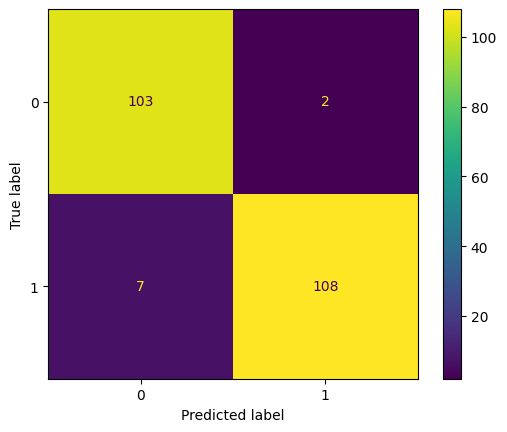

In [49]:
knn.fit(train_hist, train_label)
y_hat = knn.predict(test_hist)

metrics(y_hat, test_label)

### Logistic Regression

In [40]:
logistic_params = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    k = range(3,13,3)
)
logistic = make_pipeline(
    SimpleImputer(strategy='mean'), # we may also pick Median as the strategy
    LogisticRegression(solver='liblinear')) # we may pick a different K    

Logistic on all the channels

Accuracy:	 96.36
Precision:	 98.18
Recall:		 94.74


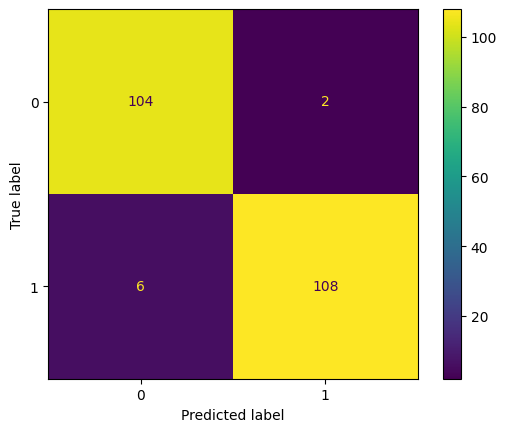

In [51]:
logistic.fit(train_hist, train_label)
y_hat = logistic.predict(test_hist)

metrics(y_hat, test_label)

Logistic on **RGB**

Accuracy:	 87.27
Precision:	 84.55
Recall:		 89.42


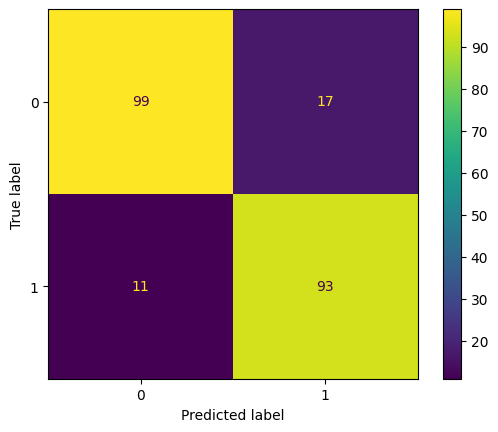

In [47]:
logistic.fit(train_hist.loc[:,feature_names[:3]], train_label)
y_hat = logistic.predict(test_hist.loc[:,feature_names[:3]])

metrics(y_hat, test_label)